# Try downloading UKB data

+ Link: https://pan-dev.ukbb.broadinstitute.org/docs/hail-format/index.html#extracting-a-subset-of-ld-matrix
+ European samples are the largest, totaling 14.1T of data
+ Tested on Sherlock with julia/1.6.2, java/11.0.11, python/3.9.0

In [25]:
using Revise
using EasyLD
using CSV
using DataFrames
using Statistics
using LinearAlgebra
using Plots
gr(fmt=:png);

First check how many files there are:

In [10]:
get_ukb_filenames("EUR", join=false)

124281-element Vector{String}:
 "part-000000-44-0-0-22f828c8-17c3-7c3c-1fa1-1fc113144aca"
 "part-000001-44-1-0-d35bc353-c9b7-28e7-315b-f1bcd8d9e50b"
 "part-000002-44-2-2-7dc4e8fd-75f7-26d0-4b9c-65628f25cf34"
 "part-000003-44-3-0-74be7ee3-ba85-f9ce-4add-9638cf387f8a"
 "part-000004-44-4-0-b11cbd6a-50e2-4e5e-ae70-932ff3aebd5f"
 "part-000005-44-5-0-104f3537-b7e4-0959-555b-7e65ca2b00ae"
 "part-000006-44-6-0-f99bebaa-7361-9c3e-65a0-2700858c2b28"
 "part-000007-44-7-0-90293a19-7ae6-f6a6-1141-48f62ee6f8b1"
 "part-000008-44-8-0-847d7052-f784-0c5f-c4f8-d16df8745a23"
 "part-000009-44-9-0-2b61d351-aeda-4c03-52aa-cb380599219d"
 "part-000010-44-10-0-90b9d808-fa98-2727-ca3e-d63676464185"
 "part-000011-44-11-0-7a15dbc9-b5c7-3500-8258-886bbf569e35"
 "part-000012-44-12-0-73b49602-7c17-3f3b-860c-6aaa8b25f36b"
 ⋮
 "part-124226-44-124226-0-9948291d-f1c5-775a-4ed3-7d75c9e7d007"
 "part-124227-44-124227-0-43ffd695-b0c7-577e-0d5a-8ea5f3ed84d0"
 "part-124228-44-124228-0-d22a4e30-04f2-82aa-dfd2-4d3ae95e57b4"
 "pa

Try downloading the first 10 files (~1GB)

In [12]:
population = "EUR"
outdir = "/Users/biona001/.julia/dev/EasyLD/data"
download_ukb_LD_matrices(population, outdir, start_from=1, num_files=10)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:48


Downloading 10 files took 228 seconds, so download all 124k files would take roughly 30 days. Fortunately, the `start_from` and `num_files` keywords allow us to split this into 30 jobs, so we should be able to download everything in 1 day or so.

# Reading the LD panel

In [2]:
data = "/Users/biona001/.julia/dev/EasyLD/data/UKBB.EUR.ldadj.bm"
bm = hail_block_matrix(data);

LoadError: UndefVarError: hail not defined

Check size of matrix

In [3]:
size(bm)

2023-03-04 10:39:14.721 WARN  Utils:69 - Your hostname, Benjamins-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 10.0.0.86 instead (on interface en0)
2023-03-04 10:39:14.726 WARN  Utils:69 - Set SPARK_LOCAL_IP if you need to bind to another address
2023-03-04 10:39:15.250 WARN  NativeCodeLoader:60 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Initializing Hail with default parameters...
Picked up _JAVA_OPTIONS: -Xmx16g
Picked up _JAVA_OPTIONS: -Xmx16g
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.1.3
SparkUI available at http://10.0.0.86:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.109-b71b065e4bb6
LOGGING: writing to /Users/biona001/.julia/dev/gnomAD/test/hail-20230304-1039-0.2.109-b71b065e4bb6.log


(23960350, 23960350)

Read first 10000 by 10000 block into memory

In [4]:
Sigma = bm[1:10000, 1:10000]

10000×10000 Matrix{Float64}:
 0.99996  0.00098559  -0.000830543  …  -0.000520665   0.00422904
 0.0      0.999942    -0.00104453      -0.00494589    0.00050959
 0.0      0.0          0.999963        -0.00129536    0.00216722
 0.0      0.0          0.0             -0.00663755    0.000142521
 0.0      0.0          0.0              0.0104731     0.000936687
 0.0      0.0          0.0          …  -0.00202249   -0.000497824
 0.0      0.0          0.0             -0.00550819    0.00283421
 0.0      0.0          0.0             -0.00145102   -0.000761935
 0.0      0.0          0.0              0.00287458   -0.0010154
 0.0      0.0          0.0             -0.000450895  -0.00130722
 0.0      0.0          0.0          …  -0.00101125    0.000451512
 0.0      0.0          0.0              0.00590455   -0.00110266
 0.0      0.0          0.0             -0.00274252   -0.000817142
 ⋮                                  ⋱                
 0.0      0.0          0.0             -0.109458     -0.00866031
 0

Check if the given block is PSD by computing its eigenvalues

In [5]:
eigvals(Symmetric(Sigma)) # Symmetric uses upper triangular portion of data

10000-element Vector{Float64}:
  -4.496303144059796e-15
  -1.762987426134658e-15
  -1.040030990442209e-15
  -4.2089306816541705e-16
  -3.960324780237165e-16
  -3.9060196040323796e-16
  -2.985734642577166e-16
  -2.8601497287222336e-16
  -2.5553650845256305e-16
  -1.998130772222011e-16
  -1.8449274904356797e-16
  -1.7028015609869147e-16
  -1.3192630645503314e-16
   ⋮
 116.57001725005479
 124.37732317876345
 125.11477060743002
 135.80425399688727
 142.93300594996916
 149.24000792252738
 161.47927858350278
 181.82233513932786
 228.3300216753156
 235.961635959381
 280.6540947869515
 322.07381500507836

## Download variant index hail table

In [ ]:
population = "EUR"
outdir = "/Users/biona001/.julia/dev/EasyLD/data"
download_ukb_variant_index_tables(population, outdir)

## Read SNP file

In [3]:
using EasyLD
ht_file = "/Users/biona001/.julia/dev/EasyLD/data/UKBB.EUR.ldadj.variant.ht"
df = read_variant_index_tables(ht_file)

Row,locus,alleles,rsid,AF,idx
,String15,String,String,Float64,Int64
1,1:11063,"[""T"",""G""]",rs561109771,4.7982e-5,0
2,1:13259,"[""G"",""A""]",rs562993331,0.00027798,1
3,1:17641,"[""G"",""A""]",rs578081284,0.00083096,2
4,1:57222,"[""T"",""C""]",rs576081345,0.00065859,3
5,1:58396,"[""T"",""C""]",rs570371753,0.00024023,4
6,1:63668,"[""G"",""A""]",rs561430336,2.7728e-5,5
7,1:69569,"[""T"",""C""]",rs2531267,0.00018542,6
8,1:79192,"[""T"",""G""]",rs557418932,8.1599e-5,7
9,1:91588,"[""G"",""A""]",rs554639997,0.00015868,8


In [10]:
locus = df[!, "locus"]
idx = findall(x -> startswith(x, "1:"), locus)
chr1_pos = split.(locus[idx], ':')
chr1_pos = parse.(Int, [chr1_pos[i][2] for i in 1:length(chr1_pos)])

1810668-element Vector{Int64}:
     11063
     13259
     17641
     57222
     58396
     63668
     69569
     79192
     91588
    533573
    541944
    542210
    565148
         ⋮
 249229734
 249229855
 249229967
 249230279
 249230793
 249230849
 249230914
 249231445
 249231938
 249232824
 249234747
 249239233

## Quasi-independent regions

Compare against ldetect: https://bitbucket.org/nygcresearch/ldetect-data/src/master/EUR/fourier_ls-chr1.bed

For example, how many SNP falls in region 1 of ldetect?

In [20]:
region_start, region_end = 10583, 1892607
count(x -> region_start ≤ x ≤ region_end, chr1_pos)

9176

Let's examine these numbers more systematically.

minimum(block_sizes) = 48
mean(block_sizes) = 13614.646616541353
median(block_sizes) = 13203.0
maximum(block_sizes) = 24183


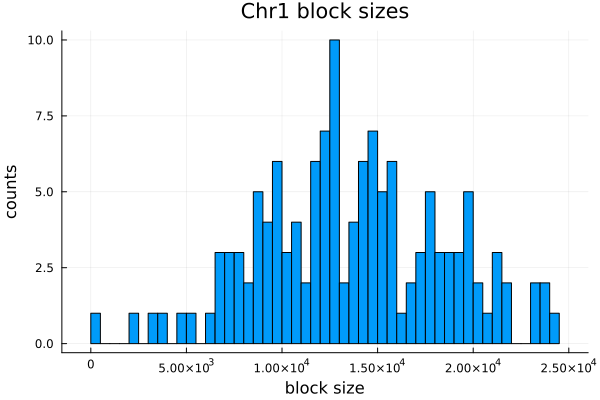

In [30]:
chr1_ldetect = CSV.read("/Users/biona001/.julia/dev/EasyLD/ldetect/EUR/fourier_ls-chr1.bed", DataFrame)
block_start = chr1_ldetect[!, 2]
block_end = chr1_ldetect[!, 3]

block_sizes = Int[]
for (st, ed) in zip(block_start, block_end)
    push!(block_sizes, count(x -> st ≤ x ≤ ed, chr1_pos))
end

@show minimum(block_sizes)
@show mean(block_sizes)
@show median(block_sizes)
@show maximum(block_sizes)

histogram(block_sizes, bins=50, label=false, xlabel="block size", ylabel="counts", title="Chr1 block sizes")

## Misc

List all files in bucket

In [5]:
using AWS: @service
using AWSS3

In [6]:
p = S3Path("s3://pan-ukb-us-east-1/ld_release/")

p"s3://pan-ukb-us-east-1/ld_release/"

In [13]:
# list files starting with UKBB.EUR
dirs = readdir(p)
dirs[findall(x -> startswith(x, "UKBB.EUR"), dirs)]

22-element Vector{String}:
 "UKBB.EUR.25LDMS.l2.M"
 "UKBB.EUR.25LDMS.l2.M_5_50"
 "UKBB.EUR.25LDMS.l2.annot.gz"
 "UKBB.EUR.25LDMS.l2.ldscore.gz"
 "UKBB.EUR.25LDMS.ldscore.ht/"
 "UKBB.EUR.25LDMS.rsid.l2.annot.gz"
 "UKBB.EUR.25LDMS.rsid.l2.ldscore.gz"
 "UKBB.EUR.8LDMS.l2.M"
 "UKBB.EUR.8LDMS.l2.M_5_50"
 "UKBB.EUR.8LDMS.l2.annot.gz"
 "UKBB.EUR.8LDMS.l2.ldscore.gz"
 "UKBB.EUR.8LDMS.ldscore.ht/"
 "UKBB.EUR.8LDMS.rsid.l2.annot.gz"
 "UKBB.EUR.8LDMS.rsid.l2.ldscore.gz"
 "UKBB.EUR.l2.M"
 "UKBB.EUR.l2.M_5_50"
 "UKBB.EUR.l2.ldscore.gz"
 "UKBB.EUR.ldadj.bm/"
 "UKBB.EUR.ldadj.variant.b38.ht/"
 "UKBB.EUR.ldadj.variant.ht/"
 "UKBB.EUR.ldscore.ht/"
 "UKBB.EUR.rsid.l2.ldscore.gz"

In [7]:
file = joinpath(p, "UKBB.EUR.ldadj.bm")
stat(file)

Status(
  device = 0,
  inode = 0,
  mode = -rw-rw-rw-,
  nlink = 0,
  uid = 501 (biona001),
  gid = 20 (staff),
  rdev = 0,
  size = 0 (0.0),
  blksize = 4096 (4.0K),
  blocks = 0,
  mtime = 0000-01-01T00:00:00,
  ctime = 0000-01-01T00:00:00,
)

In [18]:
using AWSS3

bucket = "pan-ukb-us-east-1/ld_release"
path = "UKBB.EUR.ldadj.variant.ht"
dir = joinpath("s3://", bucket, path)
readdir(S3Path(dir * "/"))

6-element Vector{String}:
 "README.txt"
 "_SUCCESS"
 "globals/"
 "index/"
 "metadata.json.gz"
 "rows/"

Download and check README file

In [19]:
outdir = "/Users/biona001/.julia/dev/EasyLD/data/UKBB.EUR.ldadj.variant.ht"
s3_get_file(bucket, joinpath(path, "README.txt"), joinpath(outdir, "README.txt"))

In [21]:
;head /Users/biona001/.julia/dev/EasyLD/data/UKBB.EUR.ldadj.variant.ht/README.txt

This folder comprises a Hail (www.hail.is) native Table or MatrixTable.
  Written with version 0.2.64-1ef70187dc78
  Created at 2021/03/30 01:57:37

Check inside `UKBB.EUR.ldadj.variant.ht/index`

In [27]:
dir = joinpath("s3://", bucket, path, "index")
idx_files = readdir(S3Path(dir * "/"))

18904-element Vector{String}:
 "part-00000-38-0-0-6427c99b-9cd4-7c36-673b-98da4d7d69bf.idx/"
 "part-00001-38-1-0-12a00088-763b-7aa0-4c75-3174e6bcaeaf.idx/"
 "part-00002-38-2-0-864c49d5-6ecf-d3d1-7a84-3208d8861c9f.idx/"
 "part-00003-38-3-0-cf8da943-a599-d21c-7209-72949a3b5e83.idx/"
 "part-00004-38-4-0-c85abe4c-f578-8d13-6c41-a4938fa27b6c.idx/"
 "part-00005-38-5-0-80482f16-5400-cabb-afe9-8ead9c502076.idx/"
 "part-00006-38-6-0-10351893-cb61-2394-4db6-50a09faa293a.idx/"
 "part-00007-38-7-0-3bea7a57-4cb6-003a-7637-c903814e2632.idx/"
 "part-00008-38-8-0-7ecdfdaa-1f51-12c0-6701-586e55c7056c.idx/"
 "part-00009-38-9-0-1f92954a-3778-713e-39d7-4293426b1fe7.idx/"
 "part-00010-38-10-0-0b33199f-e1eb-c9d3-7add-4cb5d085145b.idx/"
 "part-00011-38-11-0-052130f9-7626-6245-290f-9565c34840ff.idx/"
 "part-00012-38-12-0-ac0d7e4b-cc18-17c8-3da6-4177afff70bf.idx/"
 ⋮
 "part-18892-38-18892-0-5cf61076-1b19-e74b-b73d-68f7689e5fc5.idx/"
 "part-18893-38-18893-0-29bac184-5f5a-0788-c304-2f7a2c8b1b86.idx/"
 "part-1889

In [29]:
idx1 = idx_files[1]
dir = joinpath("s3://", bucket, path, "index", idx1)
readdir(S3Path(dir * "/"))

2-element Vector{String}:
 "index"
 "metadata.json.gz"

Download one such index file and see what it is

In [25]:
outdir = "/Users/biona001/.julia/dev/EasyLD/data/UKBB.EUR.ldadj.variant.ht/index"
filename = "part-00000-38-0-0-6427c99b-9cd4-7c36-673b-98da4d7d69bf.idx/"
s3_get_file(bucket, 
    joinpath(path, "index", filename), 
    joinpath(outdir, filename))

LoadError: AWS.AWSExceptions.AWSException: NoSuchKey -- The specified key does not exist.

HTTP.Exceptions.StatusError(404, "GET", "/pan-ukb-us-east-1/ld_release/UKBB.EUR.ldadj.variant.ht/index/part-00000-38-0-0-6427c99b-9cd4-7c36-673b-98da4d7d69bf.idx/", HTTP.Messages.Response:
"""
HTTP/1.1 404 Not Found
x-amz-request-id: CBKW09QK2DW2F7P1
x-amz-id-2: jgk6MKAruxtSyreRJ2SvJ2S1K5vfIqePzIw6S76zjeF1HJLsCI4xVjjtEjZ0VnwkC9icO9DJ8og=
Content-Type: application/xml
Transfer-Encoding: chunked
Date: Fri, 03 Mar 2023 22:41:17 GMT
Server: AmazonS3

[Message Body was streamed]""")

<?xml version="1.0" encoding="UTF-8"?>
<Error><Code>NoSuchKey</Code><Message>The specified key does not exist.</Message><Key>ld_release/UKBB.EUR.ldadj.variant.ht/index/part-00000-38-0-0-6427c99b-9cd4-7c36-673b-98da4d7d69bf.idx/</Key><RequestId>CBKW09QK2DW2F7P1</RequestId><HostId>jgk6MKAruxtSyreRJ2SvJ2S1K5vfIqePzIw6S76zjeF1HJLsCI4xVjjtEjZ0VnwkC9icO9DJ8og=</HostId></Error>


In [26]:
joinpath(path, "index", filename)

"UKBB.EUR.ldadj.variant.ht/index/part-00000-38-0-0-6427c99b-9cd4-7c36-673b-98da4d7d69bf.idx/"

## Read hail table (python)

On Sherlock, 

+ ml julia/1.6
+ ml python/3.9
+ ml java/11.0.11

In [ ]:
import hail as hl
ht = "UKBB.EUR.ldadj.variant.ht"
table1 = hl.read_table(ht)
df = table1.to_pandas() # takes a long time
df.memory_usage()

# output of df.memory_usage()
Index            128
locus      191682800
alleles    191682800
rsid       191682800
AF         215643150
idx        215643150
dtype: int64

# this errors
table1.write_many('UKBB.EUR.ldadj.variant.ht.julia', fields=('locus', 'alleles', 'rsid', 'AF'))

# this works
table1.export('UKBB.EUR.ldadj.variant.ht/UKBB.EUR.ldadj.variant.ht.tsv')

## Command line function to list files available

In [ ]:
run(`aws s3 ls --summarize --human-readable --recursive s3://pan-ukb-us-east-1/ld_release/UKBB.EUR.ldadj.bm`)

In [ ]:
run(`aws s3 ls --summarize --human-readable --recursive s3://pan-ukb-us-east-1/ld_release/UKBB.EUR.ldadj.variant.ht`)

In [ ]:
run(`aws s3 ls --summarize --human-readable --recursive s3://pan-ukb-us-east-1/ld_release/UKBB.EUR.ldadj.variant.ht/index/part-00000-38-0-0-6427c99b-9cd4-7c36-673b-98da4d7d69bf.idx/index`)

## AWS command to download a single folder

In [ ]:
aws s3 cp s3://pan-ukb-us-east-1/ld_release/UKBB.EUR.ldadj.variant.ht . --recursive